In [1]:
import numpy as np
import tmm_fast.plotting_helper as plth
from tmm_fast.vectorized_tmm_dispersive_multistack import coh_vec_tmm_disp_mstack as tmm
import matplotlib.pyplot as plt



Šaltinių sąrašas:
1. [TMM-Fast, a transfer matrix computation package for multilayer thin-film optimization: tutorial](https://opg.optica.org/josaa/fulltext.cfm?uri=josaa-39-6-1007&id=472723)


Išsikelti darbo tikslai:
1. Sukurti mokymosi su pastiprinimu aplinką skirta TMM-Fast bibliotekai
2. Sukurti DQN modelį
3. Apmokyti modelį sumodeliuoti tam tikrų parametrų daugiasluoksnę optinę plokštelę

Šiam darbui buvo pasitelkta TMM-fast biblioteka, kurią su minimaliomis modifikacijomis pavyko paleisti šioje aplinkoje.

Pavyzdinis šios bibliotekos panaudojimas pateikiamas šioje kodo iškarpoje:

In [2]:
# bangos ilgiai
wl_nm = np.linspace(400, 1200, 800, dtype=np.int64)
wl = wl_nm * (10 ** (-9))
#kritimo kampai
theta_degrees = np.linspace(0, 90, 360)
theta = theta_degrees * (np.pi / 180)


# sluoksniu skaicius
num_layers = 3

# M - perejimo matrica, su refrakcijos koeficientais kiekviename sluoksnyje, kiekvienam bangos ilgiui

M = np.ones((1, num_layers, wl.shape[0]), dtype=np.complex128)
M[:, :, :] = 1.8 + 0.05j


# danga supa vakuumas ir stiklas
M[:, 0, :] = 1
M[:, -1, :] = 1.5

# T - sluoksniu storis
T = np.ones((M.shape[0], M.shape[1]))
T[:,:] = 300 * (10 ** (-9))
T[:, 0] = np.inf
T[:, -1] = np.inf

# tmm:
O = tmm("s", M, T, theta, wl, device="cpu")






Ši biblioteka mums taip pat leidžia nusibraižyti turimus sluoksnius bei jų lūžio rodiklius: 

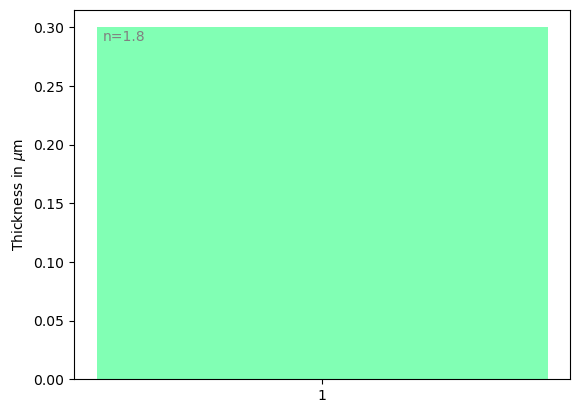

In [3]:
fig, ax = plt.subplots(1, 1)
ax, cmap = plth.plot_stacks(ax, list(M[:, 1:-1, 0]), list(T[:, 1:-1]))

Iš O kintamojo galime gauti norimus pralaidumo, bei atspindžio koeficientus atitinkamam bangos ilgiui ir kritimo kampui 

Šioje kodo iškarpoje pavaizduojame mūsų dangos pralaidumo spektrą

/var/folders/n8/rpx7n_cx0tv1_qmlqf49gsqc0000gn/T/ipykernel_33814/3306137741.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wl_labels)


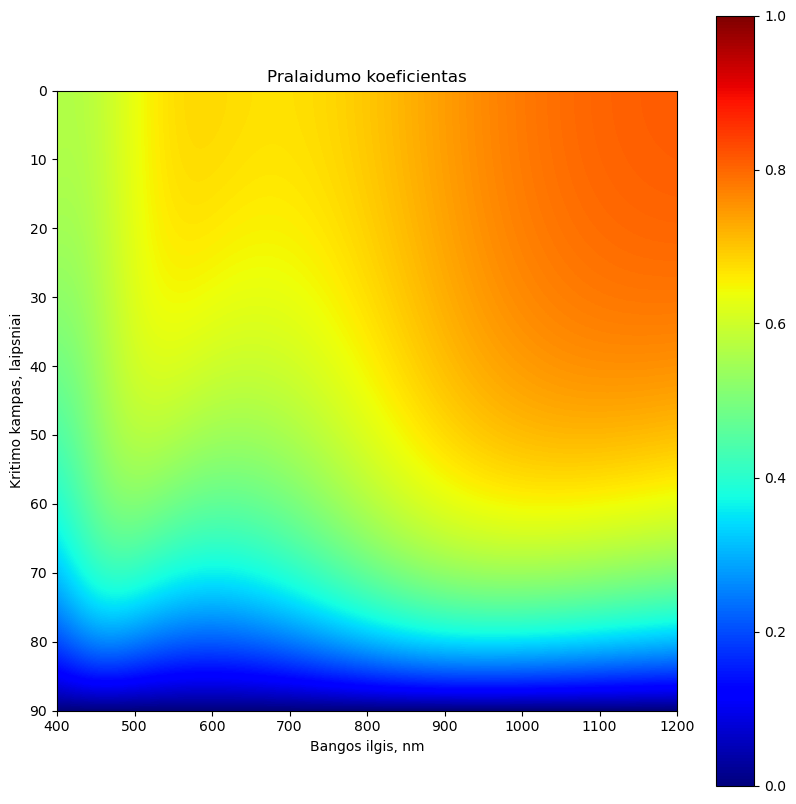

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
heat_map = ax.imshow(O['T'][0], cmap=plt.cm.jet, vmin=0, vmax=1, extent=[0, len(wl), 0, len(wl)])
ax.set_xlabel("Bangos ilgis, nm")
ax.set_ylabel("Kritimo kampas, laipsniai")
ax.set_title("Pralaidumo koeficientas")
wl_labels = np.linspace(wl_nm[0], wl_nm[-1], 9, dtype=np.int64)
ax.set_xticklabels(wl_labels)
theta_labels = np.linspace(theta_degrees[-1], theta_degrees[0], 10, dtype=np.int64)
ax.set_yticks(np.linspace(0, len(wl_nm), 10))
ax.set_yticklabels(theta_labels)
fig.colorbar(heat_map, ax=ax)
plt.show()





Šioje iškarpoje nusibrėžiame atspindžio spektrą

/var/folders/n8/rpx7n_cx0tv1_qmlqf49gsqc0000gn/T/ipykernel_33814/2354202114.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wl_labels)


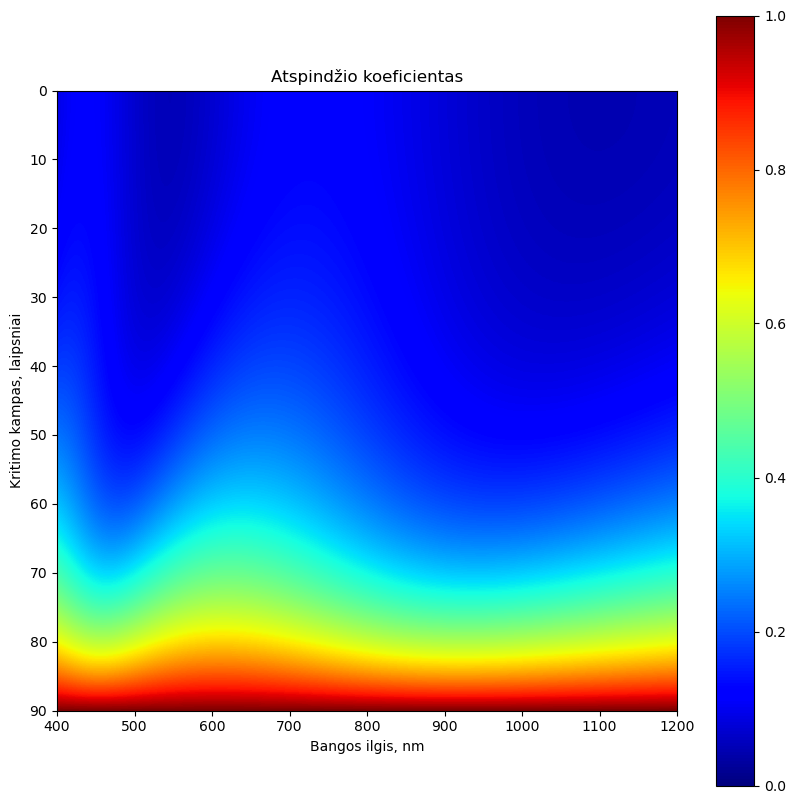

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
heat_map = ax.imshow(O['R'][0], cmap=plt.cm.jet, vmin=0, vmax=1, extent=[0, len(wl), 0, len(wl)])
ax.set_xlabel("Bangos ilgis, nm")
ax.set_ylabel("Kritimo kampas, laipsniai")
ax.set_title("Atspindžio koeficientas")
wl_labels = np.linspace(wl_nm[0], wl_nm[-1], 9, dtype=np.int64)
ax.set_xticklabels(wl_labels)
theta_labels = np.linspace(theta_degrees[-1], theta_degrees[0], 10, dtype=np.int64)
ax.set_yticks(np.linspace(0, len(wl_nm), 10))
ax.set_yticklabels(theta_labels)
fig.colorbar(heat_map, ax=ax)
plt.show()



norėdami sugeneruoti atsitiktinias daugiasluoksnes dangas parašėme funkciją, kuri gali tai padaryti iš trijų skirtingų medžiagų (Silicio Oksido, Titano (IV) Oksido  ir Cinko Oksido), tačiau svarbu atsižvelgti į tai jog šioje versijoje nėra atsižvelgiama į medžiagų sugertį ir imamos pastovios realios lūžio rodiklio vertės (nepriklausančios nuo bangos ilgio)

In [6]:
#grazina atsitiktini sluoksniu skaiciu ir sluoksniu storius tarp vakuumo ir stiklo
def get_random_sample(num_layers=None, stacks=None):
    if num_layers is None:
        num_layers = np.random.randint(3, 12)
    if stacks is None:
        stacks = np.random.randint(1, 10)
    
    # M - perejimo matrica, su refrakcijos koeficientais kiekviename sluoksnyje, kiekvienam bangos ilgiui
    M = np.ones((stacks, num_layers, wl.shape[0]))
    # SiO2, TiO2, ZnO
    materials = [1.47, 2.6142, 2.0034]
    for i in range(stacks):
        for j in range(1, num_layers - 1):
            M[i, j, :] = materials[np.random.randint(0, len(materials))]
        

    # danga supa vakuumas ir stiklas
    M[:, 0, :] = 1
    M[:, -1, :] = 1.5

    # T - sluoksniu storis
    T = np.ones((M.shape[0], M.shape[1]))
    max_t = 400 * (10 ** (-9))
    min_t = 20  * (10 ** (-9))
    T = (max_t - min_t) * np.random.uniform(0, 1, (M.shape[0], M.shape[1])) + min_t
    

    

    T[:, 0] = np.inf
    T[:, -1] = np.inf

    return M, T
    

Žemiau esančio kodo pagalba, galime pavaizduoti savo sugeneruotus rezultatus

[0.00162506103515625, 1.5570809841156006]


/var/folders/n8/rpx7n_cx0tv1_qmlqf49gsqc0000gn/T/ipykernel_33814/3979218586.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(wl_labels)


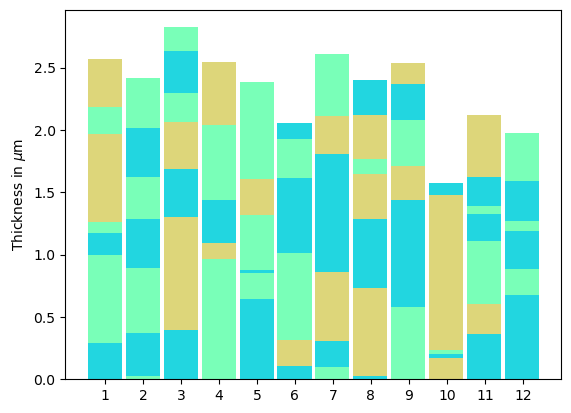

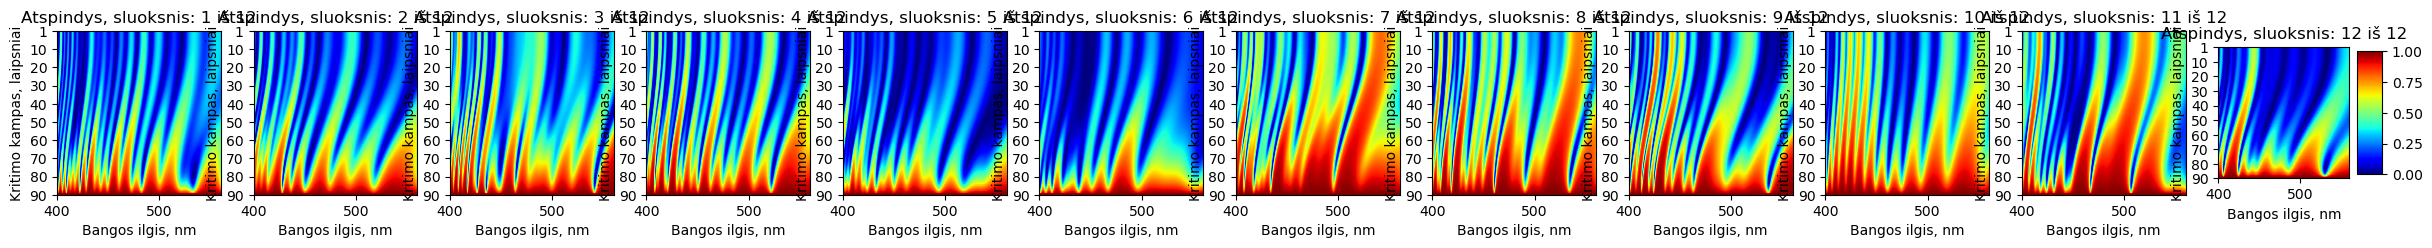

/var/folders/n8/rpx7n_cx0tv1_qmlqf49gsqc0000gn/T/ipykernel_33814/3979218586.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(wl_labels)


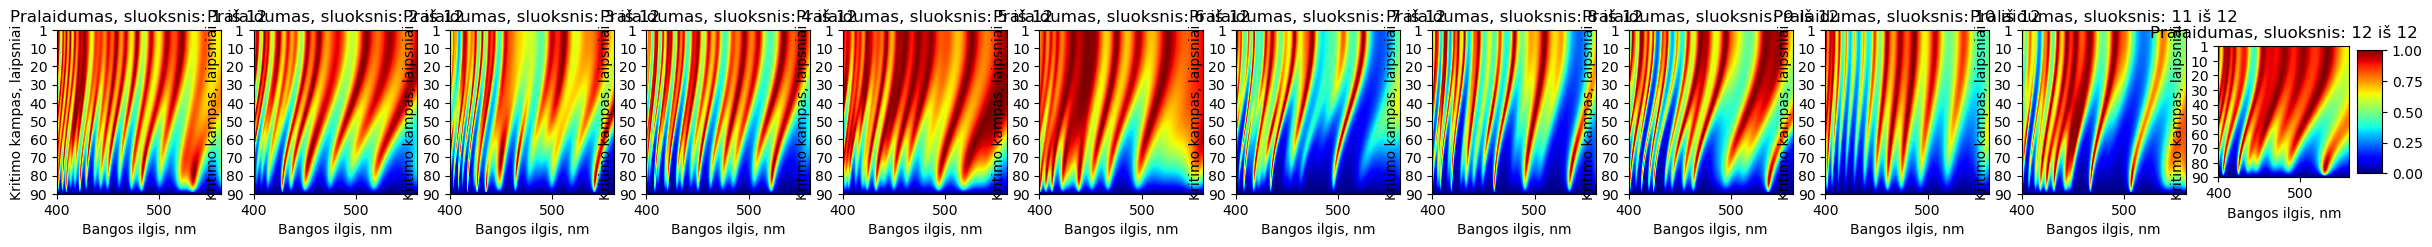

In [7]:
def plot_stacks(M,T, show_mat=True):
    fig, ax = plt.subplots(1, 1)
    ax, cmap = plth.plot_stacks(ax, list(M[:, 1:-1, 0]), list(T[:, 1:-1]), show_material=show_mat)


def plot_transmitivity(O, wl, theta_degrees):
    
    fig, ax = plt.subplots(1, len(O['T']), figsize=(30, 10*len(O['T'])), dpi=100)
    for i in range(len(O['T'])):
        heat_map = ax[i].imshow(O['T'][i], cmap=plt.cm.jet, vmin=0, vmax=1, extent=[0, len(wl), 0, len(wl)])
        ax[i].set_xlabel("Bangos ilgis, nm")
        ax[i].set_ylabel("Kritimo kampas, laipsniai")

        wl_labels = np.linspace(wl[0], wl[-1], 9, dtype=np.int64)
        ax[i].set_xticklabels(wl_labels)
        ax[i].set_title("Pralaidumas, sluoksnis: " + str(i+1) + " iš " + str(len(O['T'])))
        theta_labels = np.linspace(theta_degrees[-1], theta_degrees[1], 10, dtype=np.int64)
        ax[i].set_yticks(np.linspace(0, len(wl), 10))
        ax[i].set_yticklabels(theta_labels)
    fig.colorbar(heat_map, ax=ax[-1], aspect=5)
    plt.show()


def plot_reflectivity(O, wl, theta_degrees):

    fig, ax = plt.subplots(1, len(O['R']), figsize=(30, 10*len(O['R'])), dpi=100)
    for i in range(len(O['R'])):
        heat_map = ax[i].imshow(O['R'][i], cmap=plt.cm.jet, vmin=0, vmax=1, extent=[0, len(wl), 0, len(wl)])
        ax[i].set_xlabel("Bangos ilgis, nm")
        ax[i].set_ylabel("Kritimo kampas, laipsniai")

        wl_labels = np.linspace(wl[0], wl[-1], 9, dtype=np.int64)
        ax[i].set_xticklabels(wl_labels)
        ax[i].set_title("Atspindys, sluoksnis: " + str(i+1) + " iš " + str(len(O['R'])))
        theta_labels = np.linspace(theta_degrees[-1], theta_degrees[1], 10, dtype=np.int64)
        ax[i].set_yticks(np.linspace(0, len(wl), 10))
        ax[i].set_yticklabels(theta_labels)
    fig.colorbar(heat_map, ax=ax[-1], aspect=5)
    plt.show()


theta_degrees = np.linspace(0, 90, 90)
theta = theta_degrees * (np.pi / 180)
wl_nm = np.linspace(400, 1200, 800, dtype=np.int64)
wl = wl_nm * (10 ** (-9))



M, T = get_random_sample(12, 12)


# "s" - s-polarizuota banga, M - lūžio rodiklių matrica, 
# T - sluoksnių storis, theta - kritimo kampai, wl - bangos ilgiai,
# device - naudojama įrenginio atmintis, "cpu" arba "cuda"
O, timer = tmm("s", M, T, theta, wl, device="cpu",timer=True)


# gražinama atspindžio ir pralaidumo matrica kiekvienai dangai per
# kiekvieną bangos ilg ir kiekvieną kritimo kampą 
# bei lūžio rodiklis kiekvienai dangai per kiekvieną bangos ilgį ir kiekvieną kritimo kampą

print(timer)
plot_stacks(M, T, False)
plot_reflectivity(O, wl_nm, theta_degrees)
plot_transmitivity(O, wl_nm, theta_degrees)




Norint gauti tikslesnius rezultatus reikalinga atsižvelgti ir į lūžio rodiklio ir sugerties priklausomybę nuo bangos ilgio, todėl tam reikia pasitelkti papildomus šių duomenų žinynus.
Šio darbo kompleksiniai lūžio rodikliai buvo paimti iš [refractiveindex.info](https://refractiveindex.info) svetainės, kurioje galima rasti beveik visų medžiagų kompleksinius lūžio rodiklius

Žemiau esančio kodo tikslas perdirbti šaltinio duomenis į patogius savo aplinkai formatus

In [8]:
#perdirbame duomenis
import pandas as pd

ZnO_path = "materials/ZnO.txt"
zn_data = pd.read_csv(ZnO_path, sep=" ", header=None)
print(zn_data)
wl = zn_data[0] * 1000 # conversion to nm
n = zn_data[1] + 1j * zn_data[2]

#interpoliuojame trūkstamiems bangos ilgiams nuo 300 iki 1500 nm

xp = wl
fp = n
new_wl = np.linspace(300, 1500, 1201, dtype=np.int64)
n = np.interp(new_wl, xp, fp)

output_path = "materials/preprocessed/nZnO.txt"
output = pd.DataFrame({"wl": new_wl, "n": n})
output.to_csv(output_path, sep="\t", index=False, header=False)

SiO2_path = "tmm_fast/materials/nSiO2.txt"
si_data = pd.read_csv(SiO2_path, sep="\t", header=None)
print(si_data)
wl = si_data[0] 
n = si_data[1] + 1j * si_data[2]

#interpoliuojame trūkstamiems bangos ilgiams nuo 300 iki 1500 nm
xp = wl
fp = n
new_wl = np.linspace(300, 1500, 1201, dtype=np.int64)
n = np.interp(new_wl, xp, fp)
output_path = "materials/preprocessed/nSiO2.txt"
output = pd.DataFrame({"wl": new_wl, "n": n})
output.to_csv(output_path, sep="\t", index=False, header=False)

TiO2_path = "materials/TiO2.txt"
TiO2_data = pd.read_csv(TiO2_path, sep=" ", header=None)
print(TiO2_data)
wl = TiO2_data[0] * 1000 # conversion to nm
n = TiO2_data[1] + 1j * TiO2_data[2]

#interpoliuojame trūkstamiems bangos ilgiams nuo 300 iki 1500 nm
xp = wl
fp = n
new_wl = np.linspace(300, 1500, 1201, dtype=np.int64)
n = np.interp(new_wl, xp, fp)
output_path = "materials/preprocessed/nTiO2.txt"
output = pd.DataFrame({"wl": new_wl, "n": n})
output.to_csv(output_path, sep="\t", index=False, header=False)




         0       1         2
0    0.300  1.8403  0.196340
1    0.305  1.8293  0.193450
2    0.310  1.8179  0.194010
3    0.315  1.8074  0.198750
4    0.320  1.7997  0.207710
..     ...     ...       ...
576  3.180  1.7279  0.016335
577  3.185  1.7279  0.016344
578  3.190  1.7279  0.016353
579  3.195  1.7279  0.016363
580  3.200  1.7278  0.016372

[581 rows x 3 columns]
         0         1             2
0      300  1.492523  6.230000e-19
1      301  1.492244  5.810000e-19
2      302  1.491973  5.430000e-19
3      303  1.491684  5.070000e-19
4      304  1.491421  4.740000e-19
...    ...       ...           ...
1196  1496  1.455062  2.810000e-26
1197  1497  1.455059  2.800000e-26
1198  1498  1.455056  2.790000e-26
1199  1499  1.455054  2.780000e-26
1200  1500  1.455051  2.780000e-26

[1201 rows x 3 columns]
          0         1         2
0    0.3000  2.809982  0.592784
1    0.3010  2.813419  0.577750
2    0.3020  2.816447  0.562667
3    0.3030  2.819065  0.547550
4    0.3040  2.821271  

Atskirame faile (tmm_env.py) sukūrėme savo aplinkos klasę, kurios tikslas turėti visus mašininiam mokymuisi su pastiprinimu reikalingas funkcijas bei duomenis: aplinkos būsenos gavimą, veiksmų aplinkoje atlikimą, grįžtamojo ryšio funkciją bei pačios aplinkos simuliavimą.

Mūsų atveju aplinkos simuliavimas - daugiasluoksnės dangos "ištestavimas" su TMM-Fast biblioteka ir palyginimas su siekiamu pralaidumu/atspindžiu.

Aplinka turi maksimalų nustatytą sluoksnių skaičių, kurį galima keisti sukuriant pačią aplinką

Taip pat, į aplinką importuojame mūsų išgautus kompleksinius medžiagų lūžio rodiklius, tada juos medžiagoje galime iššaukti pasinaudojant jų indeksais: [0, 1, 2] 

Atkreipiame dėmesį, jog, mokymuisi supaprastinti buvo pasirinktas tik viena kampo vertė: 45 laipsnių kaimpas

Aplinkoje mūsų agentas galės rinktis iš diskrečių sluoksnio storių pasirinkimų: 1 nm, 5 nm, 10 nm, 15 nm, 20 nm, 25 nm, 30 nm, 35 nm, 40 nm, 45 nm

Tyrimo eigoje buvo atsisakyta naudoti aplinkos nustatymą iš naujo dėl per didelio mokymosi nestabilumo.

Gryžtamasis ryšys kode yra paskaičiuojamas pagal MSE nuotolį tarp išsikeltų atspindžio bei pralaidumo tikslų.
per kiekvieną žingsnį agentas gauna paskatą priklausoma nuo to kaip pasikeitė MSE tarp T ir R nuo paskutinio žingsnio.

Žemiau esantis kodas pavaizduoja ir ištestuoja mūsų aplinkos veikimą



(30, 1200)
[3, 10]


/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


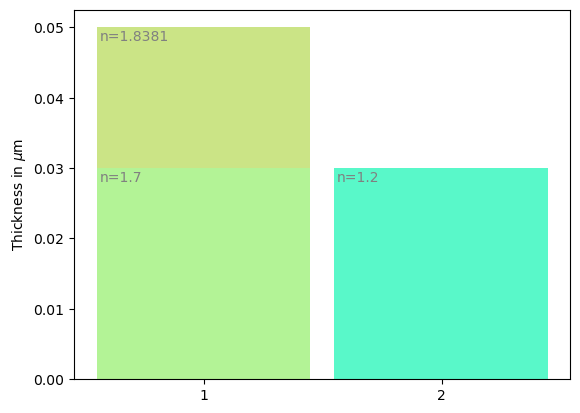

In [9]:
from tmm_env import Environment

wl = np.linspace(300, 1500, 1200, dtype=np.int64)
env = Environment(2, wl, 30)
env.add_layer(1.7, 30 * (10 ** (-9)), 0)
env.add_layer(1.2, 30 * (10 ** (-9)), 1)
#env.add_layer(0, 0, True)
env.add_layer(1, 4, 0, True)
print(env.M[0].shape)

env.plot_env()

actions = env.get_actions()
print(actions)




/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


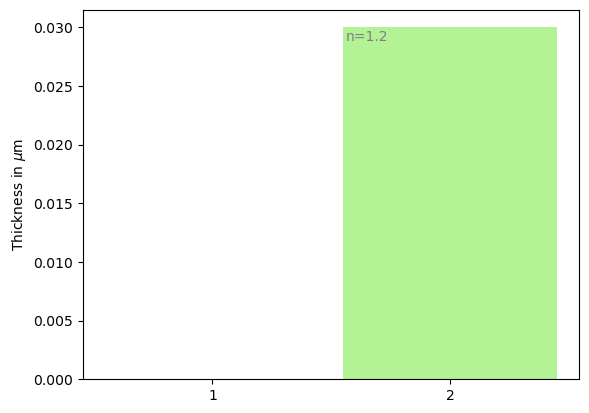

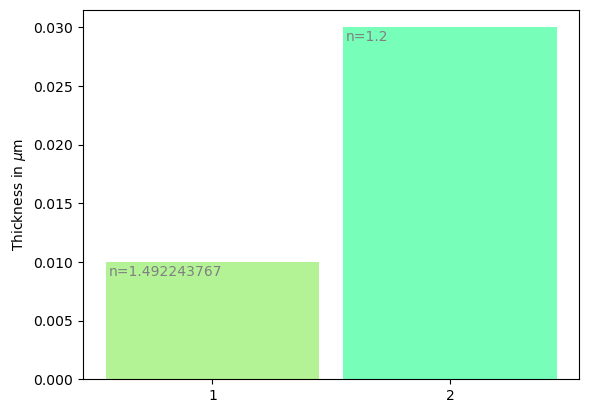

In [10]:
env.reset(0)

env.plot_env()
env.add_layer(0, 2, 0, True)
env.plot_env()


[0.2197261  0.24138479]
[-0.0544667  -0.07663534]


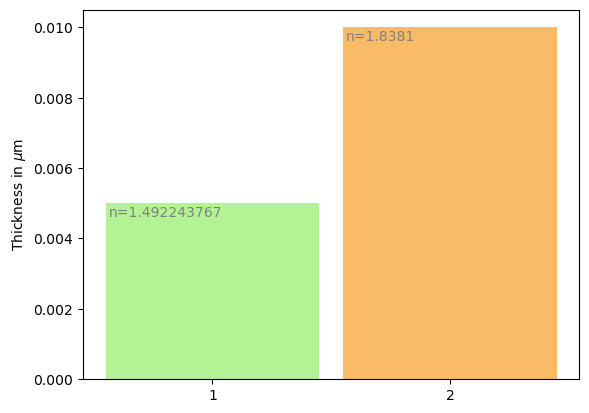

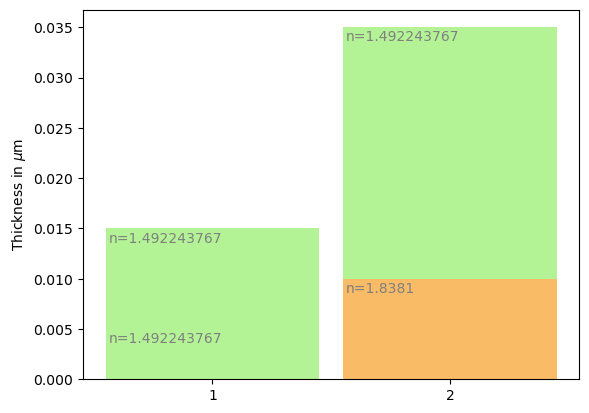

In [11]:

env.reset(1)
env.reset(0)
# atsižvelgiame į tai, kad sugertis yra:
# A = 1 - R - T
actions = [[0, 1],[1, 2]]
target_r = np.zeros((1, 1200))
target_t = np.zeros((1, 1200))
env.set_targets(1,target_r, target_t)
env.set_targets(0,target_r, target_t)
obs, reward, done = env.step(actions)
env.plot_env()
print(reward)

actions = [[0, 2],[0, 5]]
obs, reward, done = env.step(actions)
env.plot_env()
print(reward)


Sukūrėme savo gilujį Q mokymosi tinklą, kuris remiasi Q mokymusi iš patirties ir giliųjų tinklų kombinacija.

savo giliajam neuronų tinklui panaudojome 3 giliuosius sluoksnius su ReLu aktyvacijos funkcija. Visas tinklas ir jo apmokymo galimybės buvo sukurtos remiantis pytorch biblioteka.


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random

class DQNAgent:
    def __init__(self, state_size, num_layers, num_thick, ):
        self.state_size = state_size
        self.num_layers = num_layers
        self.num_thick = num_thick
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9  # discount rate
        # Šis parametras padeda agentui retkarčias vietoj geriausio veiksmo pasirinkti atstitiktin veiksmą,
        # siekiant atrasti naujų ir netikėtų sprendimo metodų (padeda išvengti lokalių minimumų)
        self.epsilon = 0.6  

        # Agentui įgyjant vis daugiau patirties, atsitiktinių veiksmų poreikis turėtų mažėti, todėl šis parametras jį mažina (padeda neperšauti mokymosi procese)
        self.epsilon_decay = 0.995
        
        self.epsilon_min = 0.01
        # atminties kiekis iš kurio mokosi agentas
        self.batch_size = 32

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # su
        self.model = self.build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_thick + self.num_layers)
        )
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            random_layers = np.random.randint(0,self.num_layers, size=(state.shape[0]))
            random_thick = np.random.randint(0,self.num_thick, size=(state.shape[0]))
            #random_reset = np.random.randint(0,1, size=(state.shape[0]))
            random_reset = np.zeros((state.shape[0]))
            return np.array([random_layers, random_thick])
        states = torch.from_numpy(state).float().to(self.device)
        states_flattened = torch.flatten(states, start_dim=1)  
        with torch.no_grad():
            q_values = self.model(states_flattened)

        action_layer = q_values[:, :self.num_layers].argmax(dim=1).detach().numpy()

        action_thick = q_values[:, self.num_layers:self.num_layers+self.num_thick].argmax(dim=1).detach().numpy()
        #action_reset = q_values[:, self.num_layers+self.num_thick:].argmax(dim=1).detach().numpy()
        
        
        return np.array([action_layer, action_thick])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states).float().to(self.device)
        actions = torch.tensor(actions).long().to(self.device)
        rewards = torch.tensor(rewards).float().to(self.device).unsqueeze(1)
        next_states = torch.tensor(next_states).float().to(self.device)
        dones = torch.tensor(dones).float().to(self.device).unsqueeze(1)
        flattened_next_states = torch.flatten(next_states, start_dim=1)
        flattened_states = torch.flatten(states, start_dim=1)
        Q_values = self.model(flattened_next_states)
    
        q_layers = Q_values[:, :self.num_layers]
        q_thick = Q_values[:, self.num_layers:self.num_layers+self.num_thick]
        #q_reset = Q_values[:, self.num_layers+self.num_thick:]

        Q_targets_next_layer = q_layers.max(1)[0].unsqueeze(1)
        Q_targets_next_thick = q_thick.max(1)[0].unsqueeze(1)
        #Q_targets_next_reset = q_reset.max(1)[0].unsqueeze(1)
        
        Q_targets_next = torch.cat((Q_targets_next_layer, Q_targets_next_thick), dim=1)
        #Q mokymosi principas paremtas tuo, kad Q vertės yra apskaičiuojamos pagal Q lygtį, kurioje yra Q vertės kitame žingsnyje 
        


        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        
        hot_actions = torch.zeros((actions.shape[0], self.num_layers+self.num_thick), dtype=torch.int64).to(self.device)
        hot_actions.scatter_(1, actions, 1)

        Q_values = self.model(flattened_states)

        Q_values_layer = Q_values[:, self.num_layers:]
        Q_values_thick = Q_values[:, self.num_layers:self.num_layers+self.num_thick]
        #Q_values_reset = Q_values[:, self.num_layers+self.num_thick:]


        Q_expected_layer = torch.sum(Q_values_layer * hot_actions[:, self.num_layers:], dim=1, keepdim=True)
        Q_expected_thick = torch.sum(Q_values_thick * hot_actions[:, self.num_layers:self.num_layers+self.num_thick], dim=1, keepdim=True)
        #Q_expected_reset = torch.sum(Q_values_reset * hot_actions[:, self.num_layers+self.num_thick:], dim=1, keepdim=True)




        
      

        Q_expected = torch.cat((Q_expected_layer, Q_expected_thick), dim=1)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        
        # agentui vis daugiau išmokstant, po truputį mažiname epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



In [15]:

obs_size = env.obs[0].shape[0] * env.obs[0].shape[1]
possible_actions = env.get_actions()
action_size = possible_actions[0] + possible_actions[1] 
#sukuriame savo agentą su parametrais iš aplinkos
agent = DQNAgent(obs_size, possible_actions[0], possible_actions[1])




turėdami agentą ir savo galėjome pradėti jo apmokymo procesą. 

Apmokymas vyko per 300 epizodų, ir kas 25 epizodus buvo vykdomas agento tinklo apmokymas iš atminties.

In [16]:
episodes = 300
stacks = 1
env = Environment(stacks, wl, 15)
# nustatytas tiklas yra praleisti pusę spektro pilnai o kitą pilnai atspindėti
# nustačius abi vertes lygias 0 galima būtų bandyti optimizuoti saulės celių sugerties dangas, kadangi sugeritis = 1 - T - R
target_r = np.zeros((1, 1200))
target_t = np.zeros((1, 1200))
target_r[:, 0:600] = 1
target_t[:, 600:] = 1

for stack in range(stacks):
    env.reset(stack)
    env.set_targets(stack,target_r, target_t)

ep = 0
actions = agent.act(env.obs)
dones = np.zeros((stacks))
rewards = np.zeros((stacks))
state = env.obs
step = 0
n_layers = np.zeros((stacks))

while ep < episodes:
    step+=1
    actions = agent.act(state)
    #reshape actions
    shaped_actions = np.zeros((stacks, 3), dtype=np.int16)
    for i in range(stacks):
        
        shaped_actions[i,0] = actions[0][i]
        shaped_actions[i,1] = actions[1][i]
       # shaped_actions[i,2] = actions[2][i]
        n_layers[i] = env.current_layers[i]
    next_state, reward, done = env.step(shaped_actions)
    
    for i in range(stacks):
        #print(reward[i])
        rewards[i] += reward[i]

        if done[i]:
            print("episode: {}/{}, reward: {}, number of layers: {}".format(ep, episodes, rewards[i], n_layers[i]))
            ep += 1
            rewards[i] = 0
            env.set_targets(i,target_r, target_t)
        
        agent.remember(state[i], actions[:,i], rewards[i], next_state[i], done[i])
    state = next_state
    if ep % 25 == 0:
        agent.replay()




    

episode: 0/300, reward: -0.39750459159482554, number of layers: 14.0
episode: 1/300, reward: -0.5663037975844415, number of layers: 14.0
episode: 2/300, reward: -0.4959560019090572, number of layers: 14.0
episode: 3/300, reward: -0.444897048879876, number of layers: 14.0
episode: 4/300, reward: -0.32457595314004434, number of layers: 14.0
episode: 5/300, reward: -0.5198621451100778, number of layers: 14.0
episode: 6/300, reward: -0.3763806673682342, number of layers: 14.0
episode: 7/300, reward: -0.5395610325171138, number of layers: 14.0
episode: 8/300, reward: -0.30063883205172576, number of layers: 14.0
episode: 9/300, reward: -0.42754126429623757, number of layers: 14.0
episode: 10/300, reward: -0.5277778406208203, number of layers: 14.0
episode: 11/300, reward: -0.41605078328931316, number of layers: 14.0
episode: 12/300, reward: -0.40429787963042996, number of layers: 14.0
episode: 13/300, reward: -0.5021219660354929, number of layers: 14.0
episode: 14/300, reward: -0.50465802967

/var/folders/n8/rpx7n_cx0tv1_qmlqf49gsqc0000gn/T/ipykernel_33814/499662713.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402629672/work/torch/csrc/utils/tensor_new.cpp:248.)
  states = torch.tensor(states).float().to(self.device)


episode: 25/300, reward: -0.46119408377901366, number of layers: 14.0
episode: 26/300, reward: -0.4326134733661188, number of layers: 14.0
episode: 27/300, reward: -0.4717762301036217, number of layers: 14.0
episode: 28/300, reward: -0.44285667823631436, number of layers: 14.0
episode: 29/300, reward: -0.43537886027601574, number of layers: 14.0
episode: 30/300, reward: -0.5339116131973136, number of layers: 14.0
episode: 31/300, reward: -0.40775066807188204, number of layers: 14.0
episode: 32/300, reward: -0.49167953941573406, number of layers: 14.0
episode: 33/300, reward: -0.5490223222769366, number of layers: 14.0
episode: 34/300, reward: -0.5974407587658531, number of layers: 14.0
episode: 35/300, reward: -0.5491556223242163, number of layers: 14.0
episode: 36/300, reward: -0.36103927483181636, number of layers: 14.0
episode: 37/300, reward: -0.4874527110925857, number of layers: 14.0
episode: 38/300, reward: -0.3876563174219081, number of layers: 14.0
episode: 39/300, reward: -0.

pavaizduojame tinklo gautus rezultatus ir galime panaudoti tinklą praktiškai

/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/var/folders/n8/rpx7n_cx0tv1_qmlqf49gsqc0000gn/T/ipykernel_33814/324200965.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wl_labels)
/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/text.py:831: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/anaconda3/envs/physics/lib/python3.10/site-packages/matplotlib/text.py:691: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))


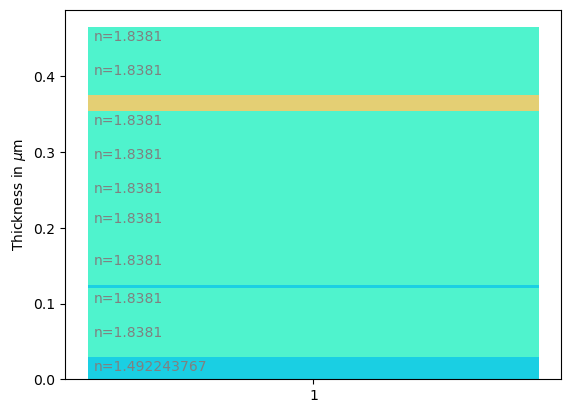

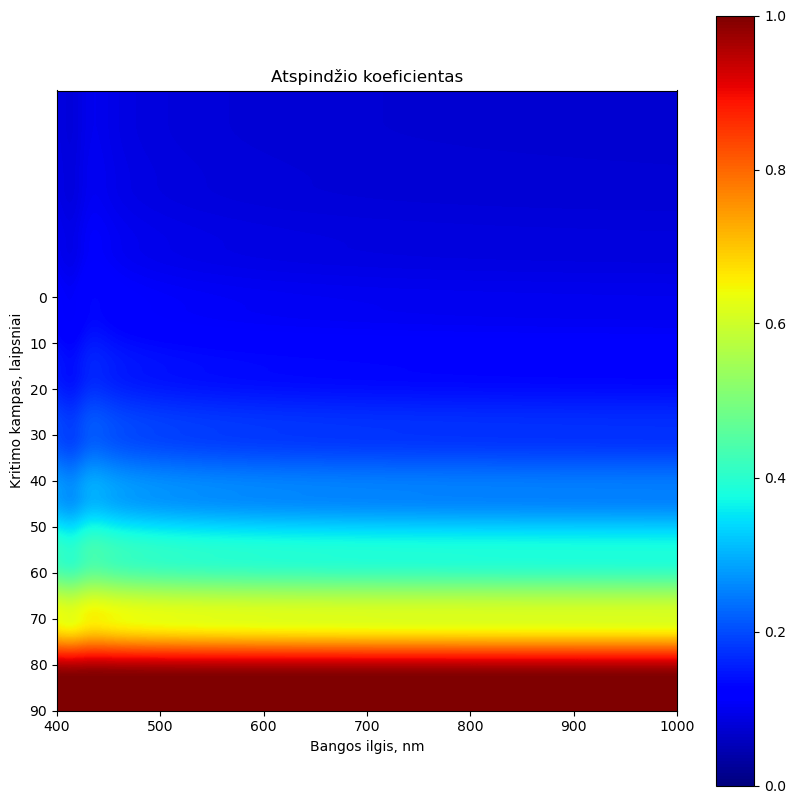

In [24]:

env = Environment(1, wl, 15)
env.reset(0)



for i in range(14):
    actions = agent.act(env.obs)
    #reshape actions
    shaped_actions = np.zeros((1, 3), dtype=np.int16)
    shaped_actions[0,0] = actions[0][0]
    shaped_actions[0,1] = actions[1][0]

    env.add_layer(shaped_actions[0,0], shaped_actions[0,1], 0, True)

env.plot_env()

O = env.compute(wl)



fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
heat_map = ax.imshow(O['R'][0], cmap=plt.cm.jet, vmin=0, vmax=1, extent=[0, len(wl), 0, len(wl)])
ax.set_xlabel("Bangos ilgis, nm")
ax.set_ylabel("Kritimo kampas, laipsniai")
ax.set_title("Atspindžio koeficientas")
wl_labels = np.linspace(wl_nm[0], wl_nm[-1], 9, dtype=np.int64)
ax.set_xticklabels(wl_labels)
theta_labels = np.linspace(90, 0, 10, dtype=np.int64)
ax.set_yticks(np.linspace(0, len(wl_nm), 10))
ax.set_yticklabels(theta_labels)
fig.colorbar(heat_map, ax=ax)
plt.show()







## Išvados

Kaip pastebėjome, mūsų sukurtam DQN modeliui nelabai pavyko tiksliai sumodeliuoti norimų parametrų, tai galėjo nutikti dėl per paprastos tinklo struktūros arba per mažo medžiagų pasirinkimo.

Vienas būdas ateityje išspręsti šią problemą būtų pasirinkti daugiau optinių medžiagų, iš jau minėtos bibliotekas.
Kitas sprendimo būdas minėtas [4] straipsnyje būtų pridėti pralaidumo ir atspindžio spektro vertes prie matomų modeliui duomenų pasitelkiant papildomus konvoliucinius sluoksnius.


Visą kodą galima rasti čia: [github.com/MartynasKer/tmm-fast](https://github.com/MartynasKer/tmm_fast)